Final Project!!
Classification of Healthy and Unhealty Patients based on the blood work

In [ ]:
!nvidia-smi

Tue Aug  6 02:19:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Load the sample data
df=pd.read_csv('/content/anemia_data.csv')    # Import the dataset
df.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


In [ ]:
# Clean and Preprocess the data
df.isnull().sum()

# Drop the NA values
df = df.dropna()

# Check for duplicate values and drop them
df_dup=df.duplicated().any()
print(df_dup)
print(df.duplicated)
if(df_dup):
  df=df.drop_duplicates()

# Show the statistics and size of Dataset
df.describe()
df.shape

True
<bound method DataFrame.duplicated of         WBC    LYMp   NEUTp     LYMn    NEUTn   RBC   HGB       HCT   MCV  \
0     10.00  43.200  50.100  4.30000  5.00000  2.77   7.3   24.2000  87.7   
1     10.00  42.400  52.300  4.20000  5.30000  2.84   7.3   25.0000  88.2   
2      7.20  30.700  60.700  2.20000  4.40000  3.97   9.0   30.5000  77.0   
3      6.00  30.200  63.500  1.80000  3.80000  4.22   3.8   32.8000  77.9   
4      4.20  39.100  53.700  1.60000  2.30000  3.93   0.4  316.0000  80.6   
...     ...     ...     ...      ...      ...   ...   ...       ...   ...   
1291   4.40  25.845  77.511  1.88076  5.14094  4.86  13.5   46.1526  80.7   
1292   5.60  25.845  77.511  1.88076  5.14094  4.85  15.0   46.1526  91.7   
1293   9.20  25.845  77.511  1.88076  5.14094  4.47  13.1   46.1526  88.7   
1294   6.48  25.845  77.511  1.88076  5.14094  4.75  13.2   46.1526  86.7   
1295   8.80  25.845  77.511  1.88076  5.14094  4.95  15.2   46.1526  89.7   

       MCH  MCHC    PLT        P

(1232, 15)

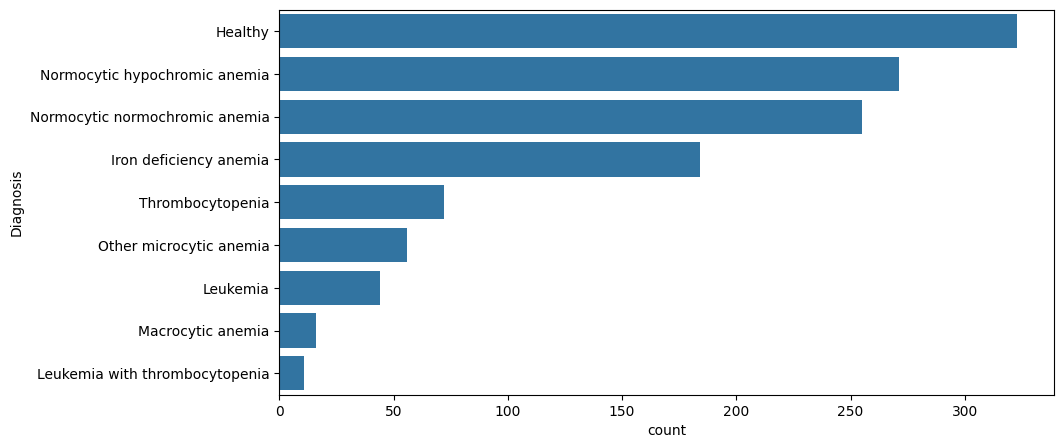

In [ ]:
# Plot a bar graph to show how many are healthy and how many are sick
plt.figure(figsize=(10, 5))
sns.countplot(y='Diagnosis', data=df, order = df['Diagnosis'].value_counts().index)
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Separate features and target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)  # Latent mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = x.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Hyperparameters
input_dim = X_scaled.shape[1]
latent_dim = 10

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize VAE model
vae = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Prepare dataset
dataset = TensorDataset(torch.tensor(X_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# Train the VAE
num_epochs = 50
vae.train()

for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        recon, mu, log_var = vae(batch[0].to(device))
        loss = criterion(recon, batch[0].to(device)) + \
               -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 1.3707
Epoch [2/50], Loss: 4.4761
Epoch [3/50], Loss: 0.9207
Epoch [4/50], Loss: 0.6300
Epoch [5/50], Loss: 0.4606
Epoch [6/50], Loss: 0.2154
Epoch [7/50], Loss: 0.3217
Epoch [8/50], Loss: 0.2948
Epoch [9/50], Loss: 0.2962
Epoch [10/50], Loss: 8.6984
Epoch [11/50], Loss: 0.6280
Epoch [12/50], Loss: 0.6854
Epoch [13/50], Loss: 0.3964
Epoch [14/50], Loss: 0.3702
Epoch [15/50], Loss: 0.4019
Epoch [16/50], Loss: 0.4033
Epoch [17/50], Loss: 0.3541
Epoch [18/50], Loss: 0.5463
Epoch [19/50], Loss: 0.2317
Epoch [20/50], Loss: 0.7061
Epoch [21/50], Loss: 0.7953
Epoch [22/50], Loss: 0.3971
Epoch [23/50], Loss: 0.7413
Epoch [24/50], Loss: 0.5425
Epoch [25/50], Loss: 0.3424
Epoch [26/50], Loss: 3.8177
Epoch [27/50], Loss: 0.3448
Epoch [28/50], Loss: 0.3769
Epoch [29/50], Loss: 0.4413
Epoch [30/50], Loss: 1.8046
Epoch [31/50], Loss: 5.3758
Epoch [32/50], Loss: 0.2524
Epoch [33/50], Loss: 0.4489
Epoch [34/50], Loss: 0.3247
Epoch [35/50], Loss: 0.4813
Epoch [36/50], Loss: 0.3137
E

In [ ]:
# Generate Synthetic Data
vae.eval()
with torch.no_grad():
    z = torch.randn(1500, latent_dim).to(device)
    synthetic_data = vae.decoder(z).cpu().numpy()

# Inverse transform the data
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_df = pd.DataFrame(synthetic_data, columns=X.columns)

# Add synthetic labels
num_classes = len(label_encoder.classes_)
synthetic_labels = label_encoder.inverse_transform(
    [i % num_classes for i in range(1500)]
)
synthetic_df['Diagnosis'] = synthetic_labels

# Save the Synthetic Dataset
synthetic_df.to_csv('synthetic_anemia_dataset.csv', index=False)

In [ ]:
# Combine original and synthetic datasets
combined_df = pd.concat([df, synthetic_df], ignore_index=True)
combined_df.to_csv('Combined_anemia_dataset.csv', index=False)

# Label as healthy (0) or unhealthy (1)
combined_df['Binary_class'] = combined_df['Diagnosis'].apply(lambda x: 0 if x == 'Healthy' else 1)

# Split into features and target
X_combined = combined_df.drop(['Diagnosis', 'Binary_class'], axis=1)
y_combined = combined_df['Binary_class']

# Standardize the features

scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

plt.figure(figsize=(10, 5))
sns.countplot(y='Diagnosis', data=combined_df, order = df['Diagnosis'].value_counts().index)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined_scaled, y_combined, test_size=0.2, random_state=42)

Accuracy: 0.9323583180987203
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79       106
           1       0.92      1.00      0.96       441

    accuracy                           0.93       547
   macro avg       0.96      0.83      0.87       547
weighted avg       0.94      0.93      0.93       547

Confusion Matrix:
 [[ 69  37]
 [  0 441]]


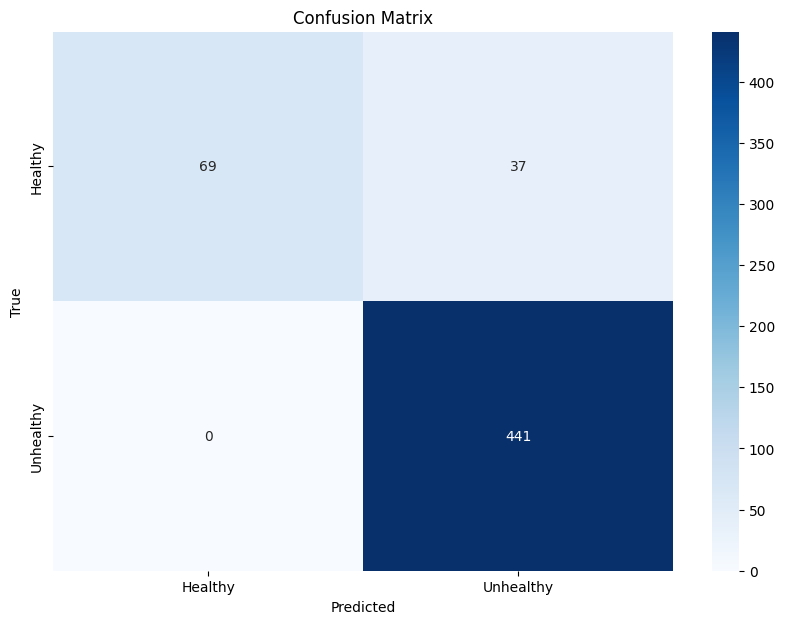

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n",cm )

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Unhealthy'], yticklabels=['Healthy', 'Unhealthy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()